# NOAA RATPAC-B Data

-----

## Initial Data Exploration

Initial data exploration for the NOAA RATPAC-B temperature data.

In [1]:
processed_data_dir = '../data/processed'

In [2]:
# Imports
import calendar
from datetime import datetime, timedelta
import os
import pickle
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate as interp

In [3]:
# Append the src/ folder to the path
sys.path.append(os.path.abspath('../src'))
from idw import tree as idw_tree

In [4]:
# Load data
with open(os.path.join(processed_data_dir, 'ratpac_stations.pkl'), 'rb') as fin:
    station_data = pickle.load(fin)

with open(os.path.join(processed_data_dir, 'ratpac_b.pkl'), 'rb') as fin:
    ratpac_data = pickle.load(fin)

# - Merge to add location data and dates
all_data = ratpac_data.join(station_data.loc[:, ['LAT', 'LON']], on='station_number')

dt_data = np.empty((all_data.shape[0], 1), dtype=datetime)
for row_id, row_vals in enumerate(all_data.values):
    dt_data[row_id] = datetime(row_vals[1], row_vals[2], 
                               calendar.monthrange(row_vals[1], row_vals[2])[1])
all_data['Date'] = dt_data

all_data.drop(['year', 'month', 'station_number', 'station_id'], axis=1, inplace=True)

In [5]:
# - Interested in the Surface and 200 through 70mb data from 1965 onward
altitudes = ['200mb', '150mb', '100mb', '70mb']
cut_data = all_data.loc[:, ['Date', 'LON', 'LAT', 'surface'] + altitudes].copy()
cut_data = cut_data.loc[cut_data.loc[:, 'Date'] >= datetime(1965, 1, 1)]

altitude_weights = np.log([float(x[:-2]) for x in altitudes]).reshape(1, len(altitudes))

all_alt_weights = pd.DataFrame(np.repeat(altitude_weights, cut_data.shape[0], 0),
                               index=cut_data.index, columns=altitudes)
all_alt_weights = all_alt_weights.where(~cut_data.loc[:, altitudes].isnull())
all_alt_weights = all_alt_weights.div(all_alt_weights.sum(axis=1), axis=0)

cut_data['aloft'] = cut_data.loc[:, altitudes].multiply(all_alt_weights).sum(axis=1)
cut_data.drop(altitudes, axis=1, inplace=True)

# - Need to reshape the data to make it easier to work with
positions = list(zip(cut_data.loc[:, 'LON'].astype(float), 
                     cut_data.loc[:, 'LAT'].astype(float)))
cut_data['Position'] = positions
cut_data.drop(['LON', 'LAT'], axis=1, inplace=True)
cut_data.set_index(['Date', 'Position'], inplace=True)

In [6]:
# - Create 3D Matrices: (date, longitude, latitude)
unq_dates = np.sort(np.unique(cut_data.index.get_level_values('Date')))

grid_names = ['surface', 'aloft']
blank_grid = np.full((len(unq_dates), 360, 180), np.nan)

raw_grids = dict()
orig_point_data = dict()
interp_point_data = dict()
for nm in grid_names:
    raw_grids[nm] = blank_grid.copy()
    orig_point_data[nm] = list()
    interp_point_data[nm] = list()

for i_dt in range(len(unq_dates)):
    dt = unq_dates[i_dt]
    t_sub_df = cut_data.loc[dt]
    
    r_lons, r_lats = zip(*t_sub_df.index.values)
    r_lons = np.array(r_lons)
    r_lats = np.array(r_lats)
    
    for nm in grid_names:
        t_values = t_sub_df.loc[:, nm].values
        
        idx_lons = np.round(r_lons).astype(int) + 180
        idx_lats = np.round(r_lats).astype(int) + 90
        raw_grids[nm][i_dt, idx_lons, idx_lats] = t_values
        
        t_points = np.concatenate([r_lons.reshape(-1, 1), r_lats.reshape(-1, 1)], axis=1)
        t_points = t_points[~np.isnan(t_values)]
        t_values = t_values[~np.isnan(t_values)]
        orig_point_data[nm].append((t_points, t_values))
        
        # - Tesselate for boundary wrap (probably a better way to do this)
        t_nrmpts = t_points.copy()
        t_nrmpts[:, 0] += 180
        t_nrmpts[:, 1] += 90

        quad_pts = list()
        quad_vls = list()
        for i_x in range(3):
            for i_y in range(3):
                t_qpts = t_nrmpts.copy()
                t_qpts[:, 0] += 360 * i_x
                t_qpts[:, 1] += 180 * i_y

                quad_pts.append(t_qpts)
                quad_vls.append(t_values.copy())

        quad_pts = np.concatenate(quad_pts, axis=0)
        quad_vls = np.concatenate(quad_vls, axis=0)

        quad_pts[:, 0] -= (360 + 180)
        quad_pts[:, 1] -= (180 + 90)

        qpt_mask = (quad_pts[:, 0] >= -360) & (quad_pts[:, 0] <= 360) \
                   & (quad_pts[:, 1] >= -180) & (quad_pts[:, 1] <= 180)

        quad_pts = quad_pts[qpt_mask]
        quad_vls = quad_vls[qpt_mask]
        interp_point_data[nm].append((quad_pts, quad_vls))

In [7]:
# - Interpolate the data (inverse distance weighted interpolation)
#   See: https://github.com/paulbrodersen/inverse_distance_weighting/
i_dt = 0

interp_results = dict()
for nm in ['surface', 'aloft']:
    print('Interpolating {} data... '.format(nm), end='', flush=True)
    interp_results[nm] = np.zeros((len(unq_dates), 360, 180))
    
    # - Loop here
    intrp_pts, intrp_vals = interp_point_data[nm][i_dt]

    g = np.mgrid[-360:360, -180:180]
    g = np.reshape(g, (2, -1)).T
    idw_interp = idw_tree(intrp_pts, intrp_vals)
    g_int = idw_interp(g)
    t_result = g_int.T.reshape((720, 360))

    interp_results[nm][i_dt] = t_result[180:(180+360), 90:(90+180)]
    
    print('DONE')

Interpolating surface data... DONE
Interpolating aloft data... DONE


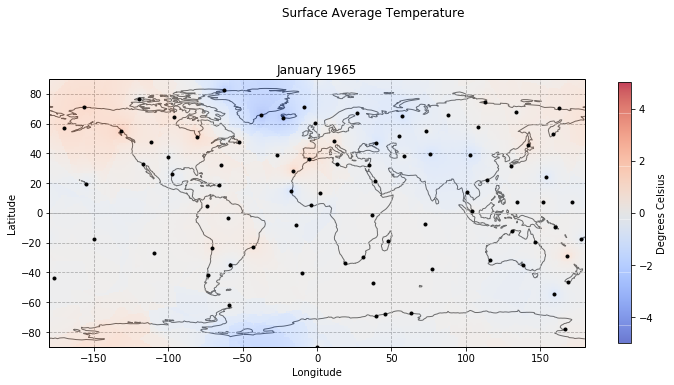

In [8]:
# - Generate Plots
nm = 'aloft'
show_values = False
normalize = True

vmin = -5.0
vmax = 5.0
center = 0.0

t_result = interp_results[nm][i_dt]
orig_pts = orig_point_data[nm][i_dt]

# - Normalize
t_normed = t_result.copy()

if normalize:
    t_normed[t_result < center] = np.maximum(t_result[t_result < center] / vmin, -1) * vmin
    t_normed[t_result >= center] = np.minimum(t_result[t_result >= center]/ np.abs(vmax), 1) * vmax
else:
    vmin = None
    vmax = None
    
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

hmap = ax.imshow(t_normed.T, extent=[-180, 180, -90, 90], interpolation='none', 
                 cmap='coolwarm', origin='lower', alpha=0.5, zorder=2,
                 vmin=vmin, vmax=vmax)
ax.scatter(orig_pts[0][:, 0], orig_pts[0][:, 1], marker='.', color='black', 
           zorder=3, alpha=1, label='Station')

if show_values:
    i_curr = 0
    for x, y in orig_pts[0]:
        ax.text(x+3, y-2, np.round(orig_pts[1][i_curr], 1), color='blue')
        t_x, t_y = int(np.round(x)+180), int(np.round(y)+90)
        ax.text(x-15, y-2, np.round(t_result[t_x, t_y], 1), color='red')
        i_curr += 1

ax.coastlines(zorder=0, alpha=1.0)
cbar = plt.colorbar(hmap, shrink=0.8)
cbar.set_label('Degrees Celsius')

ax.axhline(0, linestyle='-', linewidth=0.75, color='grey', zorder=1)
ax.axvline(0, linestyle='-', linewidth=0.75, color='grey', zorder=1)

ax.set_title('{}'.format(pd.to_datetime(unq_dates[i_dt]).strftime("%B %Y")))
ax.set_xlabel('Longitude')
ax.xaxis.set_visible(True)

ax.set_ylabel('Latitude')
ax.yaxis.set_visible(True)

ax.grid(True, color='grey', linestyle='--', alpha=1, zorder=1)

fig.suptitle('Surface Average Temperature')
plt.show();